Team Gordon

Student Name	Student Number
 Alisha Sahota	20497348
 Anthony Ramelo	20499391
 Chris Wu	10182394
 Elizabeth Zhang	20161231
 Emily Zhao	10096273
 Sam Hossain	20466500


Segmentation Data Columns: Index(['ID', 'Disbursement Date', 'Loan Status', 'Loan Amount',
       'Outstanding Balance', 'Outstanding Principal', 'Interest Rate',
       'Loan Term (Months)', 'Date of Birth', 'Gender', 'Province',
       'Residential Status', 'Stated Income on application',
       'Qualified / Verified\nIncome', 'Aptitude for change Score',
       'Financial Literacy Score', 'Self Assessments', 'Quiz Count',
       'Mood Count', 'Inspiration Count', 'Total Activies',
       'Average total activities per month', 'Average activities per day',
       'Debt_to_Income_Ratio', 'Remaining_Loan_Percentage',
       'Loan_to_Income_Ratio', 'Monthly_Repayment_Burden', 'Consistency_Score',
       'Age', 'Elapsed_Months', 'Remaining_Tenure', 'Cluster'],
      dtype='object')


/var/folders/mr/l3x9p9wd385gcyns864s9f2w0000gn/T/ipykernel_89579/2562615518.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  goals_data.fillna(0, inplace=True)



Validation Set Classification Report (Gradient Boosting - Tuned):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00         9

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36


Test Set Classification Report (Gradient Boosting - Tuned):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.89      1.00      0.94         8

    accuracy                           0.97        36
   macro avg       0.94      0.98      0.96        36
weighted avg       0.98      0.97      0.97        36



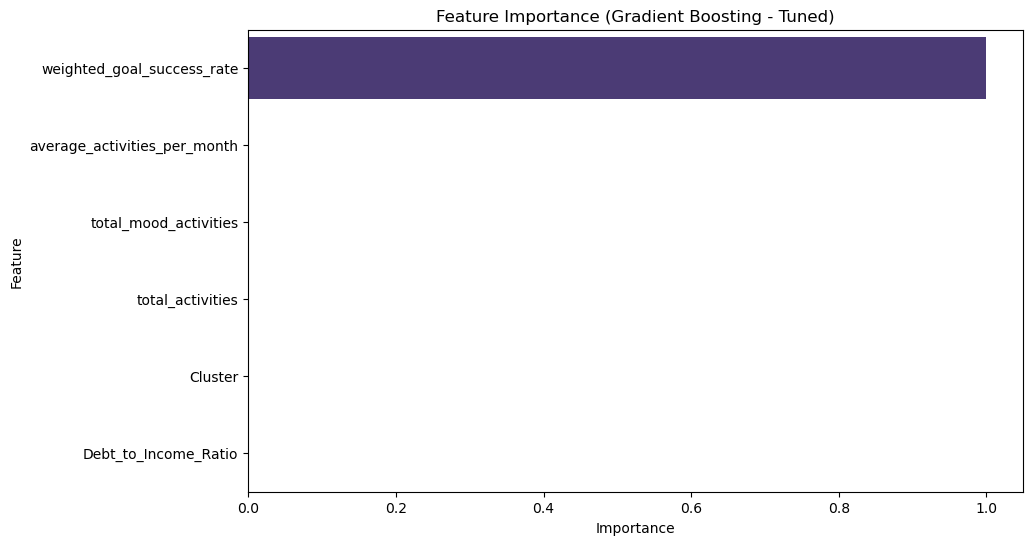


Validation Set Classification Report (Regularized Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00         9

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36


Test Set Classification Report (Regularized Random Forest):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.89      1.00      0.94         8

    accuracy                           0.97        36
   macro avg       0.94      0.98      0.96        36
weighted avg       0.98      0.97      0.97        36



In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Load datasets
file_path = 'Data 3 - October, 2024.xlsx'  # Replace with the actual path
segmentation_file_path = 'output/final_output_with_clusters.csv'  # Replace with the actual path

engagement_data = pd.read_excel(file_path, sheet_name='Monthly Wellness and Engagement')
goals_data = pd.read_excel(file_path, sheet_name='Goals_and_plans_ALLDATA_202410')
segmentation_data = pd.read_csv(segmentation_file_path)

# Add prefix to public_id and convert dates to datetime
goals_data['public_id'] = '1' + goals_data['public_id'].astype(str)
engagement_data['date'] = pd.to_datetime(engagement_data['month'])
goals_data['assessment_completed_date'] = pd.to_datetime(goals_data['assessment_completed_date'])
engagement_data['month'] = engagement_data['date'].dt.to_period('M')

# Handle missing values
engagement_data.fillna(0, inplace=True)
goals_data.fillna(0, inplace=True)
segmentation_data.fillna(0, inplace=True)

# Debugging: Check segmentation_data columns
print("Segmentation Data Columns:", segmentation_data.columns)

# Rename 'ID' to 'loanid' if it exists
if 'ID' in segmentation_data.columns:
    segmentation_data.rename(columns={'ID': 'loanid'}, inplace=True)
else:
    raise KeyError("The 'ID' column is not found in the segmentation data. Please check the dataset.")

# Ensure segmentation data 'loanid' is a string
segmentation_data['loanid'] = segmentation_data['loanid'].astype(str)

# Aggregate engagement data
engagement_summary = engagement_data.groupby(['loanid', 'month']).agg(
    total_quizzes=('quiz_answer_count', 'sum'),
    total_mood_activities=('mood_answer_count', 'sum'),
    total_inspiration_activities=('inspiration_answer_count', 'sum'),
    total_self_assessments=('self_assessment_count', 'sum'),
    total_activities=('activities_count', 'sum'),
    average_activities_per_month=('activities_count', 'mean')
).reset_index()

# Compute goal completion metrics
goal_completion_summary = goals_data.groupby('public_id').agg(
    total_goals=('goal_no_new_debt', 'count'),
    goals_no_new_debt=('goal_no_new_debt', 'sum'),
    goals_paid_bills_on_time=('goal_paid_bills_on_time', 'sum'),
    goal_paid_parachute_on_time=('goal_paid_parachute_on_time', 'sum'),
    goals_under_utilization=('under_utilization', 'sum')
).reset_index()

goal_completion_summary['weighted_goal_success_rate'] = goal_completion_summary.apply(
    lambda x: (0.4 * x['goals_no_new_debt'] +
               0.3 * x['goals_paid_bills_on_time'] +
               0.2 * x['goal_paid_parachute_on_time'] +
               0.1 * x['goals_under_utilization']) / x['total_goals'] if x['total_goals'] > 0 else 0,
    axis=1
)

# Create binary target for goal success
high_success_threshold = goal_completion_summary['weighted_goal_success_rate'].quantile(0.75)
goal_completion_summary['goal_success_binary'] = goal_completion_summary['weighted_goal_success_rate'].apply(
    lambda x: 1 if x >= high_success_threshold else 0
)

# Merge features and target
engagement_summary['loanid'] = engagement_summary['loanid'].astype(str)
goal_completion_summary['public_id'] = goal_completion_summary['public_id'].astype(str)
merged_data = pd.merge(
    engagement_summary.groupby('loanid').mean().reset_index(),
    goal_completion_summary[['public_id', 'goal_success_binary', 'weighted_goal_success_rate']],
    left_on='loanid',
    right_on='public_id',
    how='inner'
)

# Merge customer segmentation data
merged_data = pd.merge(
    merged_data,
    segmentation_data,
    on='loanid',
    how='inner'
)

# Correct features and target
# Replace 'cluster_label' with 'Cluster' (from segmentation data)
# 'engagement_to_success_ratio' needs to be created or replaced
features = [
    'total_activities',
    'average_activities_per_month',
    'total_mood_activities',
    'weighted_goal_success_rate',
    'Cluster',  # Example segmentation feature
    'Debt_to_Income_Ratio',  # Additional feature from segmentation
]
target = 'goal_success_binary'
X = merged_data[features]
y = merged_data[target]

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Gradient Boosting with Hyperparameter Tuning
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
gb_model = GradientBoostingClassifier(random_state=42)
grid_search = RandomizedSearchCV(gb_model, param_dist, n_iter=50, cv=3, scoring='f1', random_state=42, n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)
best_gb_model = grid_search.best_estimator_

# Evaluate Gradient Boosting
y_val_pred = best_gb_model.predict(X_val)
print("\nValidation Set Classification Report (Gradient Boosting - Tuned):")
print(classification_report(y_val, y_val_pred))
y_test_pred = best_gb_model.predict(X_test)
print("\nTest Set Classification Report (Gradient Boosting - Tuned):")
print(classification_report(y_test, y_test_pred))

# Feature importance for Gradient Boosting
feature_importances = best_gb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance (Gradient Boosting - Tuned)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Regularized Random Forest
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=50,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced'
)
rf_model.fit(X_resampled, y_resampled)

# Validation Set Evaluation for Random Forest
y_val_rf_pred = rf_model.predict(X_val)
print("\nValidation Set Classification Report (Regularized Random Forest):")
print(classification_report(y_val, y_val_rf_pred))

# Test Set Evaluation for Random Forest
y_test_rf_pred = rf_model.predict(X_test)
print("\nTest Set Classification Report (Regularized Random Forest):")
print(classification_report(y_test, y_test_rf_pred))